# NUMAR Unit Model  
Original paper: Chen, Ronghua & Twilley, Robert. (1999). A Simulation Model of Organic Matter and Nutrient Accumulation in Mangrove Wetland Soils. Biogeochemistry. 44. 93-118. 10.1007/BF00993000. https://www.researchgate.net/publication/226714484_A_Simulation_Model_of_Organic_Matter_and_Nutrient_Accumulation_in_Mangrove_Wetland_Soils
- Python Script of NUMAN: TOM Kaiser
- Initial modification from NUMAN to NUMAR: Fontenot, A. (2022). Wetland soil development along salinity and hydrogeomorphic gradients in active and inactive deltaic basins of coastal Louisiana.
- Initial Python script of NUMAR from NUMAN script: Christensen A., Fontenot A.
- Modified version of NUMAR: Biswas, P., Twilley R. R., Rovai A., Cassaway, A., Vargas-Lopez I. (2024)
- Python Script: Biswas P.
- Modified script for the feldspar version: February 29, 2024 (Spyder)
- Jupyter ipynb script: Biswas P., April 25, 2024

In [3]:
import os
import sys

# For Google Colab Only:

In [4]:
if os.path.isdir('/content/deltax_workshop_2024'):
  !rm -r /content/deltax_workshop_2024
! git clone https://github.com/ornldaac/deltax_workshop_2024.git

%cd /content/deltax_workshop_2024/tutorials/6_NUMARModel/Site_example


Cloning into 'deltax_workshop_2024'...
remote: Enumerating objects: 567, done.
remote: Counting objects: 100% (260/260), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 567 (delta 117), reused 203 (delta 93), pack-reused 307
Receiving objects: 100% (567/567), 119.63 MiB | 10.55 MiB/s, done.
Resolving deltas: 100% (222/222), done.
Updating files: 100% (131/131), done.
[Errno 2] No such file or directory: '/content/deltax_workshop_2024/tutorials/6_NUMARModel/Site_example'
/Users/alchrist/Documents/GitHub/deltax_workshop_2024/tutorials/6_NUMARModel/Site_example


# ***Importing Libraries/Packages***
- Make sure your working environment has all the packages it requires mentioned in ***Cell #1***. If you don't have any packages, install it before running.

In [5]:
# Cell #1

# Importing necessary libraries
import numpy as np
import pandas as pd
import scipy.integrate
import matplotlib.pyplot as plt


# ***Define the input CSV file directory***
- *in Jupyter Notebook version, it detects the location automatically*

In [6]:
# Cell #2

# Define the input CSV file containing parameters for all sites
main_folder = os.getcwd()  # Gets the current working directory
input_file_path = os.path.join(main_folder, "input_parameters", "site_parameters.csv")
print(f"Constructed input file path: {input_file_path}")

Constructed input file path: /Users/alchrist/Documents/GitHub/deltax_workshop_2024/tutorials/6_NUMARModel/Site_example/input_parameters/site_parameters.csv


# ***Constructing Data Frame from CSV***
- *Check if the data frame has been constructed correctly*

In [7]:
# Cell #3

# Reading the CSV files and store as a data frame
parameter_df = pd.read_csv(input_file_path)
print(parameter_df)

                Site basin    hydro_zone        lat         long      oms  \
0    Active Brackish    AT  intertidlal   29.301853    -91.10426  0.03360   
1     Active Saline     AT  intertidlal   29.243788    -91.10454  0.05080   
2  Inactive Brackish    TE  intertidlal   29.345400  -90.8855057  0.04600   
3   Inactive Saline     TE  intertidlal   29.171219    -90.82439  0.10279   

        si       b0    bi    c0    c1  c2    c4       e   fc1    kb      kc  \
0  0.09759  0.05600  1.99  0.03  0.03   0  0.25  0.0200  0.41  0.58  0.0109   
1  0.09613  0.08500  1.99  0.06  0.03   0  0.25  0.0345  0.43  0.31  0.0109   
2  0.06700  0.05024  1.99  0.07  0.02   0  0.25  0.0500  0.48  0.37  0.0109   
3  0.40968  0.05542  1.99  0.02  0.04   0  0.25  0.0406  0.41  0.37  0.0109   

       kl       kr      r0  
0  0.0039  0.94702  0.0035  
1  0.0039  0.58043  0.0054  
2  0.0039  2.65094  0.0022  
3  0.0039  2.02555  0.0080  


# ***Calculation***
- comments inside the code explain the process in detail
- It will save individual sites and one all site csv in a folder named "output_files"
- User doesn't have to define the directory unless they want to save in a different directory

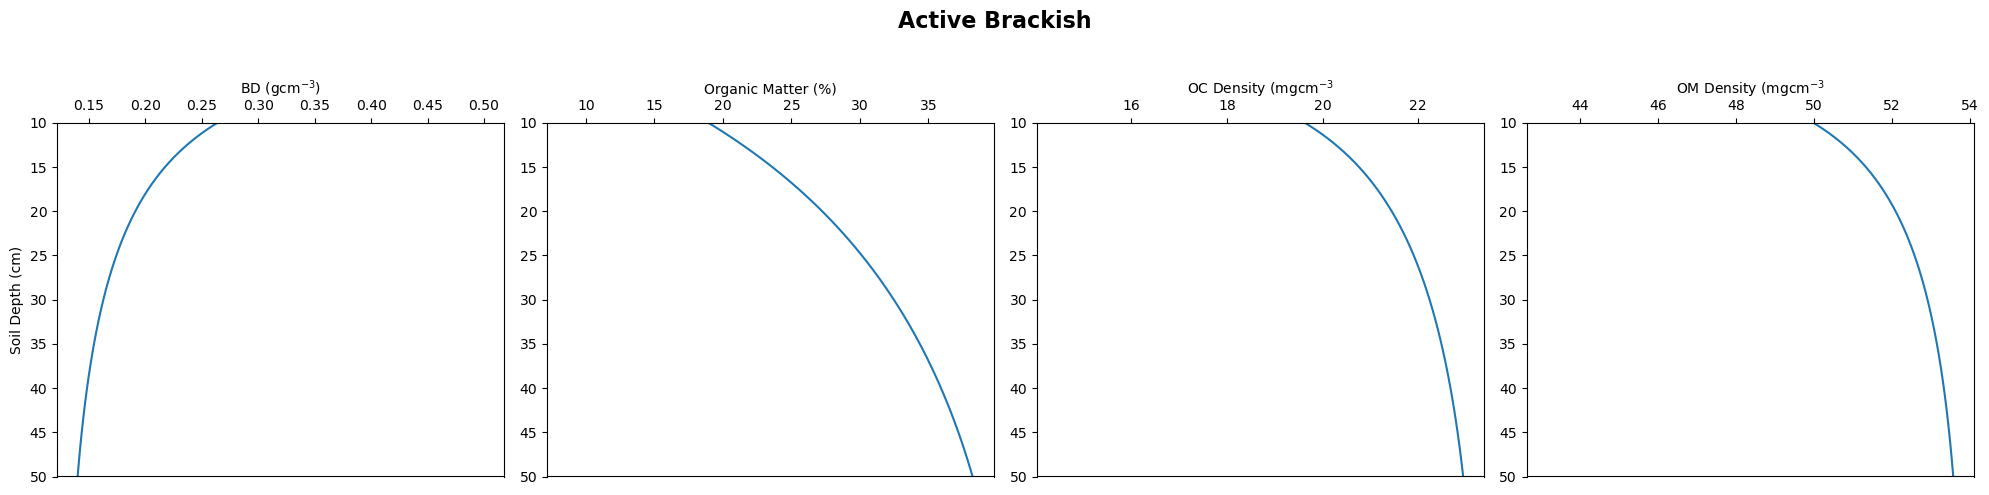

site Active Brackish basin AT lat 29.3018532 long -91.10426 hydrogeomorzone intertidlal  completed


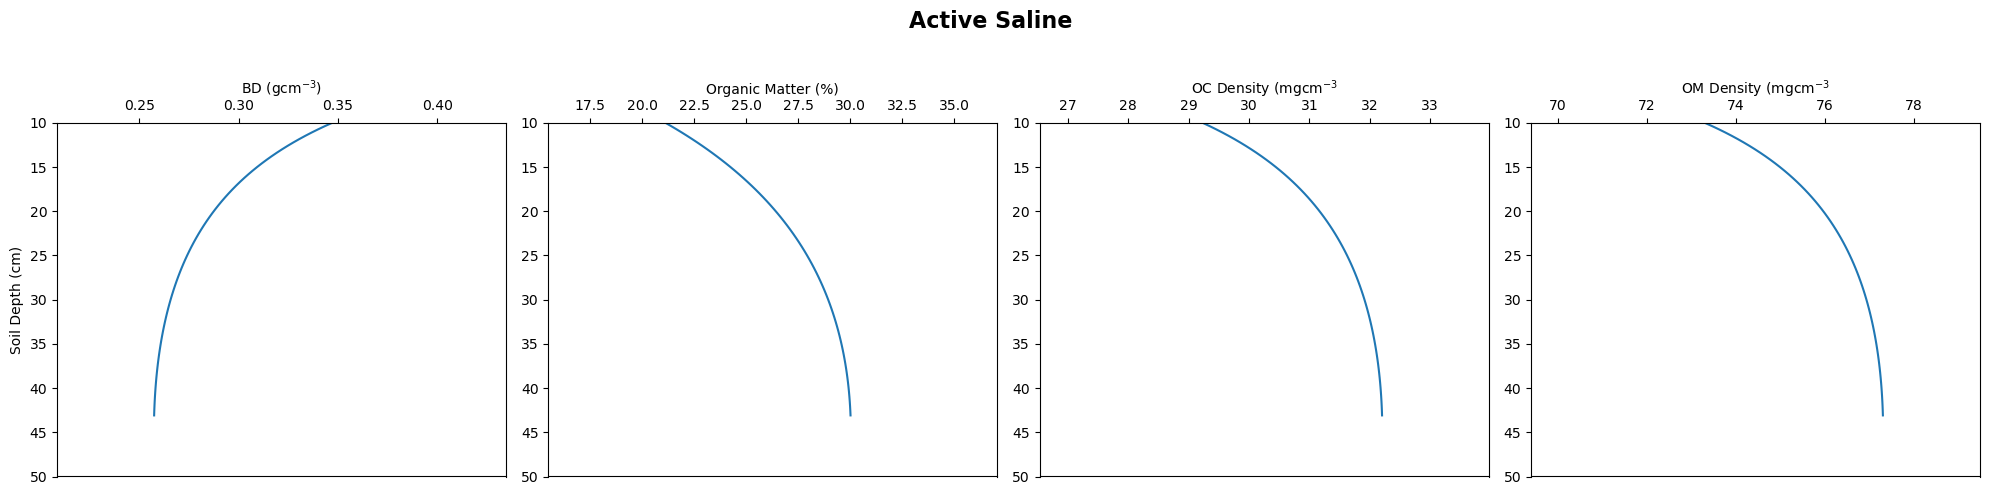

site Active Saline  basin AT lat 29.2437878 long -91.10454 hydrogeomorzone intertidlal  completed


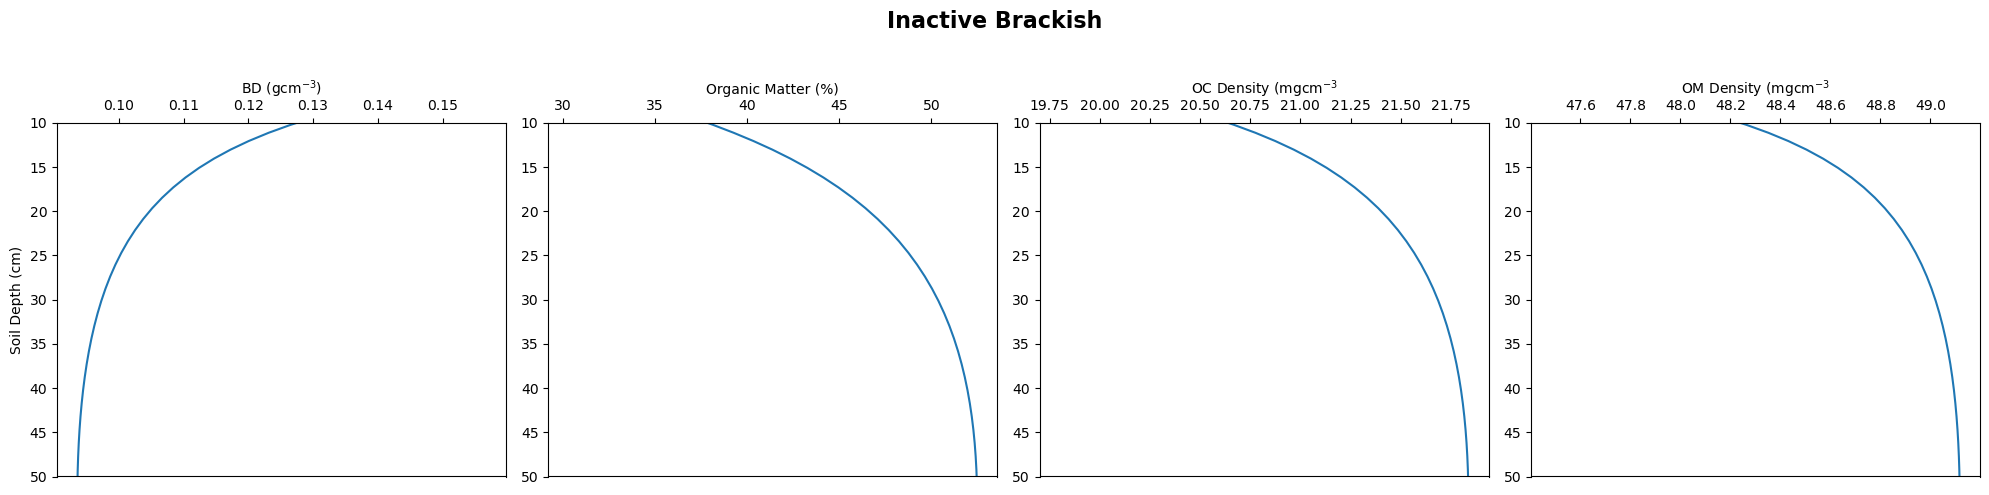

site Inactive Brackish basin TE lat 29.3454 long -90.8855057 hydrogeomorzone intertidlal  completed


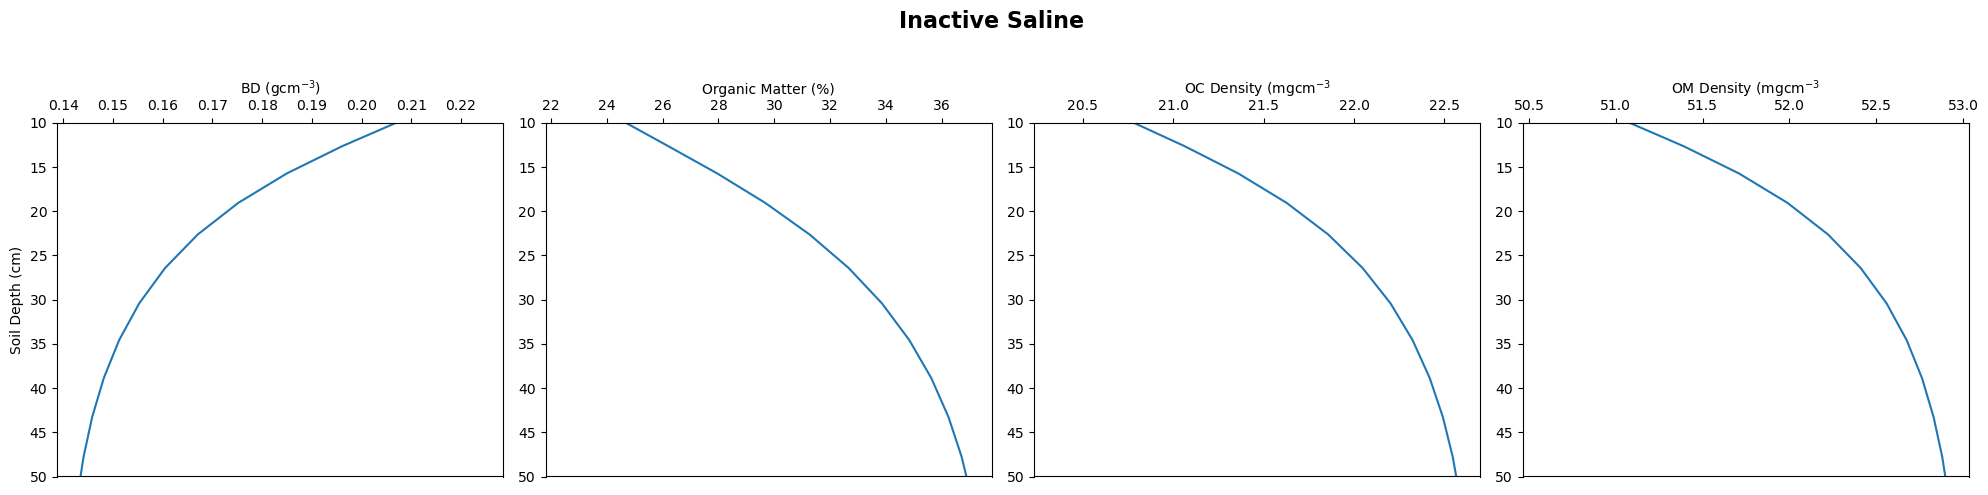

site Inactive Saline  basin TE lat 29.1712189 long  -90.82439 hydrogeomorzone intertidlal  completed


In [8]:
# Cell #4

# The calculation refers to from year 0 (initial cohort deposition) to the 100 years' old cohort.
# Discrete Counting i.e. 0,1,2,3,........99 (total 100 years)
# list1 stores different years data for each site in CSV files for calculation
# list4 stores the end product of each site's calculation like total accretion, ultimate soil properties up to the total soil accretion calculated or predicted
list1 = [[] for _ in range(0, 100)]
list4=[[]]
#------------------------------------------------------------------------------


#------------------------------------------------------------------------------
# Iterating over each site and perform calculations according to the serial provided in the excel files in the site column
for index, site_params in parameter_df.iterrows():
    try:
        # parameter extraction
        site_name = site_params['Site'] # extracts the site name as a variable
        basin_name = site_params['basin'] # extracts basin name
        hydrogeozone_name = site_params['hydro_zone'] # Extracts hydrogeomorphic zone
        lat = site_params['lat'] # latitude
        long=site_params['long'] # longitude
        oms = site_params['oms'] # organic matter loading rate on the surface over feldspar (g/cm2/yr)
        si = site_params['si'] # inorganic matter loading rate on the surface over feldspar (g/cm2/yr)
        b0 = site_params['b0'] # self packing density of pure organic matter (g/cm3)
        bi = site_params['bi'] # self packing density of pure inorganic matter (g/cm3)
        c0 = site_params['c0'] # lignin content in the surface deposit (Dry matter) in g/g
        c1 = site_params['c1'] # ash content in the root (in dry mass) in g/g
        c2 = site_params['c2'] # cellulose content in the surface deposit (dry matter) in g/g
        c4 = site_params['c4'] # cellulose content in the roots (dry mass) in g/g
        e = site_params['e'] # root attenuation, or root distribution rate (/cm)
        fc1 = site_params['fc1'] # lignin content in the fine root (dry mass) in g/g
        kb = site_params['kb'] # anaerobic decomposition rate of labile organic matter (/yr)
        kc = site_params['kc'] # cellulose decomposition rate (/yr)
        kl = site_params['kl'] # lignin decomposition rate (/yr)
        kr = site_params['kr'] # fine root turnover rate (/yr)
        r0 = site_params['r0'] # root biomass at the surface (g/cm2)

        # Inorganic matter on the surface cohort wi_0, g/cm2/yr is same as si for feldspar technique
        wi_0 = si

        # Estimation estimation of high (dt) & bottom depth of the cohort through iteration
        def upp_depth_approx(dt, db, r, e, p, wi, bi, c): # defining function
            # r = root biomass at the surface, g/cm2
            # e = root attenuation, or distribution rate, /cm,
            # p = OM's bulk or self-packing density (g/cm3)
            # bi = self packing density of inorganic matter (g/cm3)
            # c = Ash content (fraction) in the DM of the cohort (g/g)
            udepth = db
            count = 0
            diff = 1
            while diff > 0.000001:
                # r(t) = integration of (r0*exp(-eD)) from dt to db
                # D is soil depth in cm
                integr = scipy.integrate.quad(lambda d: r * np.exp(-e * d), dt, udepth)[0]  # total root biomass in a cohort
                ldepth = udepth
                # previous db will be dt for nxt cohort. this function iterates to find the next db
                # it is similar way Morris & Bowden 1986 and Chen & Twilley (1999) did through iteration to confirm there is no more significant difference between both sides.
                # We separated the root mass organic section from the inorganic to make sure that any addition of organic mistakenly from inorganic will give rise to the volume cohort
                udepth = db + (integr * (1 - c) / p) + ((wi + integr * c) / bi)  # p=b0
                diff = np.abs(udepth - ldepth)  # this iteration will stop if abs(i(n+1)-i(n))<0.0000001
                count += 1  # this iteration cycle will continue until the difference is 0.000001 or less between the function evaluated and the iterated value of db itself
            return udepth  # Once it fulfills the criteria imposed, the loop will be terminated automatically and the data will be stored

        # initializing calculation setting initial values to zero
        LOM = ROM = ROM_cell = ROM_lig = LOM_a = ROM_a = ROM_a_cell = ROM_a_lig = LOM_Nr = ROM_Nr = dt = db = frp  = TOM = V = db_corr = BD = OM_Per = Age = S_m_OM = S_m_OM_C = S_m_BD = S_m_C_Seq = S_m_OC_gPcc = S_m_IM_P = S_m_IM_Con = S_necromass = S_root_Nr = 0.0

        # initiate loop to start calculation
        for i in range(0, 100):
            # the range corresponds to the tenure up to which the calculation has to be carried out
            if i == 0:
                # Corresponds initial deposition
                # lignin and cellulose fraction are expressed as a fraction in the dry sample.
                # So, if we multiply the corresponding fraction with a dry sample, we will get corresponding lignin and cellulose in terms of g/cm2/yr
                # Labile organic matter to the cohort initially, g/cm2/yr, corresponds to LOM(0)
                # Drymass = oms + wi_0
                # ROM_cell(0): cellulose component in the surface cohort
                # ROM_cell(0) = drymass*c2
                ROM_cell = (oms + wi_0) * c2

                # ROM_lig(0): lignin component in the surface cohort

                # ROM_lig = (oms + wi_0) * c0
                ROM_lig = (oms + wi_0) * c0

                # Labile organic matter to the cohort initially, g/cm2/yr, corresponds to LOM(0)
                # labil organic matter LOM(0)=oms - refractory organic matter = oms - ROM_cell(0) - ROM_lig(0)
                LOM = oms - ROM_cell - ROM_lig

                # Refractory ROM (0) is comprised of cellulose (ROM_cell(0)) & Lignin (ROM_lig (0))

                # Refractory organic matter to the cohort initially corresponds to ROM(0) is the sum of cellulose and lignin pools
                ROM = ROM_cell + ROM_lig

                # Above ground contribution to a specific cohort

                # Above ground contribution to labile pool
                # on the surface, materials from aboveground are predominant. So, above ground litter LOM_a contribution is
                LOM_a = LOM
                # Similarly, above ground contribution to refractory cellulose pool
                ROM_a_cell = ROM_cell
                # Above ground contribution to refractory lignin pool
                ROM_a_lig = ROM_lig
                # Above ground contribution to refractory pool
                ROM_a = ROM_a_cell + ROM_a_lig

                # Rest of the thing should be from the Necro mass of root
                # Necro root contribution to labile pool
                LOM_Nr = LOM - LOM_a
                # Necro root contribution to refractory pool
                ROM_Nr = ROM - ROM_a

            else:
                # k=kb, all over
                # the reason we used below ground decomposition rate all over the depth is, the accreted organic matter has already undergone aerobic respiration and then we are getting the first cohort.
                # for NUMAR the decomposition rate k is always kb all over the depth in this model
                # Labile fraction of root is (1- ash fraction - cellulose fraction -lignin fraction)

                # Labile organic fraction LOM(t+1) = LOM(t)-kb*LOM(t)+ (1-fc1-c4-c1)*frp(t)
                # frp(t) is fine root tunover
                # So, for the next cohorts onwards, LOM will be:
                LOM = list1[i - 1][1] - kb * list1[i - 1][1] + (
                            (1 - (fc1 + c4 + c1)) * list1[i - 1][8]
                )

                # see list1, according to the index, it calls the previous year's value to calculate new year's
                # e.g. list1[i-1][1], index 1 is LOM and it calls the previous year's LOM to maintain it's numerical difference nature of this model

                # Similarly, refractiory cellulose pool

                ROM_cell = list1[i - 1][2] - kc * list1[i - 1][2] + (
                            list1[i - 1][8] * (c4))
                # And efractory lignin pool
                ROM_lig = list1[i - 1][3] - kl * list1[i - 1][3] + (
                            list1[i - 1][8] * fc1)

                # Total Refractory pool for the specific cohort
                ROM = ROM_cell + ROM_lig

                # Above ground contribution can be calculated by just tracking the retaining labile and refractoy pool as it was initially using the decay constants each steps

                # Remaining labile from above ground litter
                LOM_a = list1[i - 1][21] - kb * list1[i - 1][21]

                # Remaining cellulose from the aboveground litter
                ROM_a_cell = list1[i - 1][22] - kc * list1[i - 1][22]

                # Remaining lignin from the aboveground litter
                ROM_a_lig = list1[i - 1][23] - kl * list1[i - 1][23]

                # Total remaining refractory from aboveground thing
                ROM_a = ROM_a_cell + ROM_a_lig

                # Necro mass of root is the remaining other than the aboveground remaining contribution after decay

                # Labile Necro root mass LOM_Nr is simply Difference of total Labile & total remaining labile organic matter
                LOM_Nr = LOM - LOM_a

                # Refractory necro root mass ROM_Nr (similary)
                ROM_Nr = ROM - ROM_a
            # Cohort's lower depth calculation
            # we considered that after first 50 cm of soil depth, the root biomass is negligible: can be considered as zero
            # From Lei et al. (2020), irrespective of the different marsh site characteristics, the maximum rooting depth is 50 cm (see box plots in Figure 1)
            # main concept is root biomass is not present up to an infinite depth of soil, after the assigned rooting depth, at any depth beyond the rooting depth the root biomass is negligible
            # for model purposes, it is 0
            if dt <= 50:
                db = upp_depth_approx(dt, dt + ((LOM + ROM) / b0), r0, e, b0, wi_0, bi, c1)
                # db calls the derived function to perform the iteration on the basis of the data available

                # Root biomass in a cohort at any specific year
                rt = (scipy.integrate.quad(lambda d: r0 * np.exp(-e * d), dt, db)[0])
            else:
                # after rooting depth root biomass rt in a cohort is assigned to 0
                rt = 0.0
                db = dt + ((LOM + ROM + rt * (1 - c1)) / b0) + (wi_0 + rt * c1) / bi

            # fine root production (frp)= Total root(rt) x fine root turnover (kr)
            frp = rt * kr

            # Total Organic Matter is TOM.
            # we have LOM and ROM already. just need to add the root organic matter part (rt*(1-c1)) with it
            TOM = (LOM + ROM + rt * (1.0 - c1))

            # inorganic matter in a specific cohort specific time
            # it is a assumption of original NUMAN model that the dead root's inorganic matter will not retain in the soil. Perhaps, it will be taken away by the plant uptakes
            # So, the wi_0 stays but, we need to add live root biomass's inorganic fraction to complete the total inorganic pool in a cohort
            wi_t = wi_0 + rt * c1


            # volume of the cohort per unit surface area
            # volume  = (total organic matter / self packing density of OM) + (Total inorganic matter/self packing density of IM)
            # v in cm3
            V = ((TOM) / b0) + (wi_t / bi)

            # corrected depth
            db_corr = dt + V

            # bulk density (BD, cm3)
            # V = Total mass of cohort/ cohort volume
            BD = (TOM + wi_t) / (db_corr - dt)

            # All the places wherever you will see any soil property  is being multiplied by the volume, the only reason is, we are facilitating the weightage average based on cohort volume, not the arithmatic average in this case.
            # the total product along depth divided by total depth will produce average soil properties

            m_BD = BD * (db_corr - dt)  # bulk density x cohort volume or height
            S_m_BD = S_m_BD + m_BD  # Arithmatic sum of (Bulk Density x cohort volume or height)

            # ASH FREE DRY WEIGHT (AFDW) & Organic Matter % (OM%) are the same
            OM_Per = (TOM / (TOM + wi_t)) * 100.00
            m_OM = OM_Per * (db_corr - dt)  # OM% x cohort volume or height
            S_m_OM = S_m_OM + m_OM  # sum of (OM%x cohort volume or height)

            # OC is the fraction organic matter
            # Holmquist et al. 2017
            OC = 0.074 * ((OM_Per / 100) ** 2) + 0.421 * (OM_Per / 100) - 0.0080

            # Organic matter density in g/cm3
            OC_gPcc = BD * OC
            m_OC_gPcc = OC_gPcc * (db_corr - dt) * 1000  # 1000 is to convert it to mg # OC x cohort volume or height
            S_m_OC_gPcc = S_m_OC_gPcc + m_OC_gPcc  # Sum of (OC X cohort volume or height)

            # carbon sequestration for each cohort (g/m2/yr) = each cohort height per year (cm/yr) x organic carbon density (g/cm3)*10**4
            C_Seq = (db_corr - dt) * OC_gPcc * (10 ** 4)  # g/m2 for every year's cohort
            m_C_Seq = C_Seq * (db_corr - dt)  # C_seq x cohort volume or height
            S_m_C_Seq = S_m_C_Seq + m_C_Seq  # sum of (C_seq x cohort volume or height)

            # Organic matter density
            OM_C = BD * OM_Per * 1000 / 100  # organic matter density, mg/cm3
            m_OM_C = OM_C * (db_corr - dt)  # OM density x cohort volume or height
            S_m_OM_C = S_m_OM_C + m_OM_C  # Sum of (OM density x cohort volume or height)

            # inorganic %
            IM_P = (100 - OM_Per)  # %
            m_IM_P = IM_P * (db_corr - dt)  # Inorganic matter% x cohort volume or height
            S_m_IM_P = S_m_IM_P + m_IM_P  # sum of (Inorganic matter% x cohort volume or height)

            # Inorganic matter density in  mg/m3, similarly like carbon and organic matter density
            IM_Con = (IM_P * BD) * 1000 / 100  # Inorganic matter density (converted to mg/cm3)
            m_IM_Con = IM_Con * (db_corr - dt)  # Inorganic matter density x cohort volume or height
            S_m_IM_Con = S_m_IM_Con + m_IM_Con  # sum of (Inorganic matter density x cohort volume or height )

            # Necro mass:
            # Total necromass = total LOM and ROM. because they represent the whole dead pool in a cohort
            necro_mass = LOM + ROM  # necromass of a specific cohort
            S_necromass = S_necromass + necro_mass  # sum of necromass up to a certain depth after a certain year simulation

            # Root necromass = total labile and refractory originated from the root
            Root_Nr = LOM_Nr + ROM_Nr  # root necromass of a specific cohort
            S_root_Nr = S_root_Nr + Root_Nr  # sum of root necromass up to a certain depth after a certain year simulation

            # volume contribution for 1 cm2 area
            # volume contribution is just their respective mass divided by the appropriate self packing density
            Va = (LOM_a + ROM_a) / b0  # aboveground litter contribution to cohort
            Vr = (rt * (1 - c1)) / b0  # root contribution organic portion
            VNr = (LOM_Nr + ROM_Nr) / b0  # Necromass contribution
            Vi = wi_t / bi  # inorganic contribution

            # Volume contribution percentage
            # Volume contribution % = (specific element's contribution in a cohort / total volume of the cohort for all elements) x 100%
            Va_P = Va * 100 / V
            Vr_P = Vr * 100 / V
            VNr_P = VNr * 100 / V
            Vi_P = Vi * 100 / V



            Age = i

            # concept of array or matrices has been used for calculation.
            # i-1 corresponds to the immediate previous year's value
            # 4,5,6....... etc. are corresponding to the specific property as I made entry.
            # the index starts from 0, not from 1.
            # e.g.: Like LOM is [1], ROM is [2]

            list2 = []

            list2 += [Age, LOM, ROM_cell, ROM_lig, ROM, dt, db, rt, frp, TOM, wi_t, V, db_corr, BD, OM_Per, OC_gPcc * 1000, C_Seq, OM_C, IM_P, IM_Con, necro_mass * 100, LOM_a, ROM_a_cell,ROM_a_lig, ROM_a, LOM_Nr, ROM_Nr, S_root_Nr * 100, Va, Vr, VNr, Vi, Va_P, Vr_P, VNr_P, Vi_P]

            dt = db

            # previous year's Db set as new year's dt

            list1[i] = list2  # stores data
        #Saving files (.csv)

        output_folder = os.path.join(main_folder, "output_files", "individual_site")
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        # Define the output file path
        output_file_path = os.path.join(output_folder, f"basin {basin_name} site {site_name} lat {lat} long {long} hydrogeomorzone {hydrogeozone_name} output.csv")


        # Convert list1 to a pandas DataFrame
        df = pd.DataFrame(list1, columns=[
            'Age(yr)', 'LOM (g/cm2)', 'ROM_cellulose (g/cm2)', 'ROM_lignin(g/cm2)', 'ROM (g/cm2)', 'dt (cm)',
            'db (cm)', 'rt (g/cm2)', 'frp (g/cm2)', 'TOM (g/cm2)', 'wi_t (g/cm2)', 'V(cm3)',
            'db_corr (cm)', 'BD (g/cm3)', 'AFDW or OM %', 'OC Density (mg/cm3)', 'C_Seq (g/m2/yr)',
            'OM Density (mg/cm3)', 'Inorganic Matter(%)', 'Inorganic Matter Density (mg/cc)',
            'Necro_Mass (Mg/ha)', 'LOM_A (g/cm2)', 'ROM_A_cell (g/cm2)', 'ROM_A_lig(g/cm2)', 'ROM_A (g/cm2)',
            'LOM_Nr (g/cm2)', 'ROM_Nr (g/cm2)', 'Cumulative Nr (Mg/ha)', 'Vol cont to cohort from litter',
            'Vol cont to cohort from live root', 'Vol cont to cohort from necro root', 'Vol cont to cohort from inorganic',
            'Vol cont % to cohort from litter', 'Vol cont % to cohort from live root', 'Vol cont %to cohort from necro root',
            'Vol cont % to cohort from inorganic'
        ])

        # Save the DataFrame to a CSV file
        df.to_csv(output_file_path, index=False)

        # Plotting
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

        # Bulk Density
        axes[0].plot(df['BD (g/cm3)'], df['db (cm)'])
        axes[0].set_xlabel('BD (gcm$^{-3}$)')
        axes[0].set_ylabel('Soil Depth (cm)')
        axes[0].invert_yaxis()
        axes[0].set_ylim(50, 10)
        axes[0].xaxis.tick_top()
        axes[0].xaxis.set_label_position('top')

        # Organic Matter %
        axes[1].plot(df['AFDW or OM %'], df['db (cm)'])
        axes[1].set_xlabel('Organic Matter (%)')
        axes[1].invert_yaxis()
        axes[1].set_ylim(50, 10)
        axes[1].xaxis.tick_top()
        axes[1].xaxis.set_label_position('top')

        # OC Density
        axes[2].plot(df['OC Density (mg/cm3)'], df['db (cm)'])
        axes[2].set_xlabel('OC Density (mgcm$^{-3}$')
        axes[2].invert_yaxis()
        axes[2].set_ylim(50, 10)
        axes[2].xaxis.tick_top()
        axes[2].xaxis.set_label_position('top')

        # OM Density
        axes[3].plot(df['OM Density (mg/cm3)'], df['db (cm)'])
        axes[3].set_xlabel('OM Density (mgcm$^{-3}$')
        axes[3].invert_yaxis()
        axes[3].set_ylim(50, 10)
        axes[3].xaxis.tick_top()
        axes[3].xaxis.set_label_position('top')
        fig.suptitle(f"{site_name}", fontsize=16, fontweight='bold')

        plt.tight_layout(rect=[0, 0, 1, 0.95])

        #plt.tight_layout()
        plt.show()


        # Save the DataFrame to a CSV file
        #df.to_csv(output_file_path, index=False)

        print(f"site {site_name} basin {basin_name} lat {lat} long {long} hydrogeomorzone {hydrogeozone_name} completed")

        list4.append([site_name,basin_name, hydrogeozone_name, lat, long, list1[-1][12], list1[-1][12]/100, S_m_OM/list1[-1][12], S_m_OM_C/list1[-1][12], S_m_BD/list1[-1][12], S_m_C_Seq/list1[-1][12], S_m_OC_gPcc/list1[-1][12], S_m_IM_P/list1[-1][12], S_m_IM_Con/list1[-1][12], S_necromass*100, S_root_Nr*100, (list1[-1][27]+((list1[-1][27]-list1[-2][27])*(50-list1[-1][12])/(list1[-1][12]-list1[-2][12])))])

    except Exception as e:
        print(f"An error occurred during calculation for {site_name}, {basin_name}, {lat}, {long},{hydrogeozone_name}: {e}")

# ***Saving a summary CSV***
- The CSV includes all sites 100 year simulations summary

In [9]:
# Cell #5

list4 = list4[1:]
# Convert list4 to a pandas DataFrame
summary_df = pd.DataFrame(list4, columns=['site','basin','hydrogeomorphzone','lat', 'long', 'Total Accretion (cm)', 'Mean Accretion (cm/yr)', 'Mean OM%', 'Mean OM Density (mg/cm3)', 'Mean BD (g/cm3)', 'C_Seq (g/m2/yr)', 'OC Density (mg/cm3)', 'IM(%)', 'IM Density (mg/cc)', 'Necromass (Mg/ha)', 'Root Necromass (Mg/ha)', 'Root Necromass Projected Up to 50 cm (Mg/ha)'])
print(summary_df)
# Define the output folder
output_folder = os.path.join(main_folder, "output_files", "output_numar", "summary")
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Save the DataFrame to a CSV file
output_file_path = os.path.join(output_folder, "summary_output.csv")
summary_df.to_csv(output_file_path, index=False)

print(summary_df.columns)

                site basin hydrogeomorphzone        lat         long  \
0    Active Brackish    AT      intertidlal   29.301853    -91.10426   
1     Active Saline     AT      intertidlal   29.243788    -91.10454   
2  Inactive Brackish    TE      intertidlal   29.345400  -90.8855057   
3   Inactive Saline     TE      intertidlal   29.171219    -90.82439   

   Total Accretion (cm)  Mean Accretion (cm/yr)   Mean OM%  \
0             71.321538                0.713215  30.594275   
1             43.089194                0.430892  25.971487   
2            121.612379                1.216124  47.584828   
3            345.687413                3.456874  30.914193   

   Mean OM Density (mg/cm3)  Mean BD (g/cm3)  C_Seq (g/m2/yr)  \
0                 52.148164         0.189026       187.890874   
1                 75.467201         0.298647       140.245344   
2                 48.848939         0.103949       272.028812   
3                 52.118980         0.170651       773.793787   

  

In [10]:
output_file_path

'/Users/alchrist/Documents/GitHub/deltax_workshop_2024/tutorials/6_NUMARModel/Site_example/output_files/output_numar/summary/summary_output.csv'